In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U pip setuptools
!pip uninstall --yes --quiet osqp
!pip install scikit-survival

  Using cached osqp-0.6.2.post0-cp37-cp37m-manylinux2014_x86_64.whl (212 kB)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sksurv.nonparametric import kaplan_meier_estimator

In [ ]:
data_ciber= pd.read_csv("/content/drive/MyDrive/Year Three/CS4220yxy/CIBERSORT.Output_Job4.csv")
data_x_imported=pd.read_csv("/content/drive/MyDrive/Year Three/CS4220yxy/data_x.csv")
data_imp=pd.read_csv("/content/drive/MyDrive/Year Three/CS4220yxy/data_imp.csv")

In [ ]:
data_ciber['Input Sample'].nunique()

962

In [ ]:
original_data_ciber = data_ciber

In [ ]:
data_ciber = data_ciber.sort_values(by=['P-value'], ascending=True)
data_ciber = data_ciber.drop_duplicates(subset=['Input Sample'], keep="first")

In [ ]:
#data_ciber = data_ciber.drop_duplicates(subset=['Input Sample'])

In [ ]:
data_imp

,Unnamed: 0,history_other_malignancy,vital_status,last_contact_days_to,death_days_to,age_at_diagnosis,surgical_procedure_first,margin_status,ajcc_tumor_pathologic_pt,ajcc_nodes_pathologic_pn,ajcc_metastasis_pathologic_pm,anatomic_neoplasm_subdivision,histological_type,icd_o_3_histology,bcr_patient_uuid,bcr_patient_barcode,menopause_status_imputed,race_imputed,tumor_status_imputed,er_status_by_ihc_imputed,pr_status_by_ihc_imputed,her2_status_by_ihc_imputed,tumor_stage,pt,pn,pm
0,2,0,Alive,3767,inf,55,Modified Radical Mastectomy,0,TX,NX,MX,Left Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,6E7D5EC6-A469-467C-B748-237353C23416,TCGA-3C-AAAU,1.0,1,1,1.0,1.0,0.0,0.0,0.5,0.5,0.5
1,3,0,Alive,3801,inf,50,Lumpectomy,0,T2,N1a,M0,Right Upper Outer Quadrant,Infiltrating Ductal Carcinoma,8500/3,55262FCB-1B01-4480-B322-36570430C917,TCGA-3C-AALI,4.0,2,0,1.0,1.0,1.0,4.0,3.5,1.0,0.0
2,4,0,Alive,1228,inf,62,Modified Radical Mastectomy,0,T2,N1a,M0,Right,Infiltrating Ductal Carcinoma,8500/3,427D0648-3F77-4FFC-B52C-89855426D647,TCGA-3C-AALJ,4.0,2,0,1.0,1.0,0.5,4.0,3.5,1.0,0.0
3,5,0,Alive,1217,inf,52,Simple Mastectomy,1,T1c,N0 (i+),M0,Right,Infiltrating Ductal Carcinoma,8500/3,C31900A4-5DCD-4022-97AC-638E86E889E4,TCGA-3C-AALK,3.0,2,0,1.0,1.0,1.0,1.0,2.0,0.0,0.0
4,6,0,Alive,158,inf,50,Modified Radical Mastectomy,0,T2,N2a,M0,Left|Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,6623FC5E-00BE-4476-967A-CBD55F676EA6,TCGA-4H-AAAK,4.0,1,0,1.0,1.0,0.5,5.0,3.5,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,1094,0,Alive,791,inf,77,Lumpectomy,0,T1c,N0 (i-),MX,Left,Infiltrating Lobular Carcinoma,8520/3,5CD79093-1571-4F71-8136-0D84CCABDCAC,TCGA-WT-AB44,4.0,1,0,1.0,1.0,0.0,1.0,2.0,0.0,0.5
963,1095,0,Alive,292,inf,46,Modified Radical Mastectomy,0,T1c,N2a,MX,Right Lower Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,F89588E9-CA73-4465-A7FB-7246EDB45E3A,TCGA-XX-A899,4.0,1,0,1.0,1.0,0.0,5.0,2.0,4.0,0.5
964,1096,0,Alive,278,inf,68,Simple Mastectomy,0,T3,N0,MX,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,CA20249F-B7EA-4FD9-9ECB-34F74755AE35,TCGA-XX-A89A,4.0,1,0,1.0,1.0,0.0,4.0,5.5,0.0,0.5
965,1097,1,Alive,3042,inf,61,Other,2,T3,N1a,MX,Left Upper Outer Quadrant,Infiltrating Lobular Carcinoma,8520/3,23F438BD-1DBB-4D46-972F-1E8E74DDBD37,TCGA-Z7-A8R5,4.0,1,0,1.0,1.0,0.0,5.0,5.5,1.0,0.5


In [ ]:
column_of_interest = ['bcr_patient_barcode','history_other_malignancy','margin_status','age_at_diagnosis','menopause_status_imputed','race_imputed','tumor_status_imputed','er_status_by_ihc_imputed','pr_status_by_ihc_imputed','her2_status_by_ihc_imputed','tumor_stage','pt','pn','pm']
data_clinical = data_imp[column_of_interest]
data_clinical

,bcr_patient_barcode,history_other_malignancy,margin_status,age_at_diagnosis,menopause_status_imputed,race_imputed,tumor_status_imputed,er_status_by_ihc_imputed,pr_status_by_ihc_imputed,her2_status_by_ihc_imputed,tumor_stage,pt,pn,pm
0,TCGA-3C-AAAU,0,0,55,1.0,1,1,1.0,1.0,0.0,0.0,0.5,0.5,0.5
1,TCGA-3C-AALI,0,0,50,4.0,2,0,1.0,1.0,1.0,4.0,3.5,1.0,0.0
2,TCGA-3C-AALJ,0,0,62,4.0,2,0,1.0,1.0,0.5,4.0,3.5,1.0,0.0
3,TCGA-3C-AALK,0,1,52,3.0,2,0,1.0,1.0,1.0,1.0,2.0,0.0,0.0
4,TCGA-4H-AAAK,0,0,50,4.0,1,0,1.0,1.0,0.5,5.0,3.5,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
962,TCGA-WT-AB44,0,0,77,4.0,1,0,1.0,1.0,0.0,1.0,2.0,0.0,0.5
963,TCGA-XX-A899,0,0,46,4.0,1,0,1.0,1.0,0.0,5.0,2.0,4.0,0.5
964,TCGA-XX-A89A,0,0,68,4.0,1,0,1.0,1.0,0.0,4.0,5.5,0.0,0.5
965,TCGA-Z7-A8R5,1,2,61,4.0,1,0,1.0,1.0,0.0,5.0,5.5,1.0,0.5


In [ ]:
data_ciber

,Input Sample,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,NK cells resting,NK cells activated,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,P-value,Pearson Correlation,RMSE
480,TCGA-E2-A1LE,0.008958,0.000000,0.000000,0.241243,0,0.124304,0.007800,0.048074,0.055508,0.000000,0.00000,0.029551,0.000000,0.210241,0.086002,0.132604,0.008817,0.000000,0.046887,0.000000,0.000000,0.000000,0.00,0.481911,0.875567
358,TCGA-E2-A1L9,0.014768,0.000000,0.004465,0.049690,0,0.014733,0.010826,0.038385,0.056067,0.014509,0.00000,0.000000,0.000000,0.547348,0.047378,0.161518,0.000000,0.003557,0.036756,0.000000,0.000000,0.000000,0.00,0.608393,0.794148
404,TCGA-D8-A27F,0.143615,0.000000,0.025715,0.025606,0,0.060780,0.000000,0.010844,0.007247,0.000000,0.01715,0.000000,0.000000,0.486674,0.023029,0.174535,0.000000,0.000000,0.000000,0.024805,0.000000,0.000000,0.00,0.491461,0.873863
429,TCGA-A8-A097,0.063600,0.000000,0.007130,0.034507,0,0.143285,0.011600,0.017343,0.008446,0.000000,0.00000,0.002085,0.000000,0.355083,0.076384,0.176587,0.010074,0.000000,0.091557,0.000000,0.000000,0.002318,0.00,0.509056,0.861197
431,TCGA-LL-A440,0.016713,0.000000,0.000000,0.025395,0,0.089317,0.004367,0.010661,0.017463,0.000000,0.00000,0.007941,0.000000,0.500951,0.020783,0.166498,0.047010,0.000000,0.092902,0.000000,0.000000,0.000000,0.00,0.580347,0.815370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,TCGA-A7-A0DC,0.001139,0.000000,0.017514,0.000000,0,0.303777,0.000000,0.002762,0.009041,0.027162,0.00000,0.000000,0.000000,0.343503,0.002611,0.142450,0.000000,0.000000,0.150040,0.000000,0.000000,0.000000,0.72,-0.011600,1.111361
140,TCGA-UU-A93S,0.007516,0.003419,0.004206,0.058841,0,0.066358,0.023694,0.107993,0.000000,0.000000,0.00000,0.071961,0.000000,0.300316,0.071936,0.154564,0.000000,0.042645,0.082301,0.000000,0.000000,0.004250,0.72,-0.011100,1.103182
538,TCGA-E2-A1LS,0.078980,0.000000,0.002766,0.026989,0,0.257313,0.000000,0.012315,0.000000,0.080281,0.00000,0.061188,0.007215,0.000000,0.080869,0.204155,0.009758,0.000000,0.019459,0.152494,0.000000,0.006219,0.72,-0.009600,1.101196
730,TCGA-B6-A0RO,0.073998,0.000000,0.007057,0.108081,0,0.094204,0.000000,0.094410,0.000000,0.017326,0.00000,0.042580,0.143826,0.023602,0.073814,0.170911,0.004296,0.063349,0.079947,0.000000,0.002599,0.000000,0.74,-0.013300,1.078818


In [ ]:
data_ciber['bcr_patient_barcode']=data_ciber['Input Sample']
data_ciber.drop(['Input Sample'], axis=1, inplace=True)

In [ ]:
data_merged = pd.merge(data_clinical, data_ciber, on='bcr_patient_barcode')
data_merged
data_merged.to_csv("/content/drive/MyDrive/Year Three/CS4220yxy/data_merged.csv")

In [ ]:
data_imp.drop(['Unnamed: 0'],axis=1,inplace=True)

#Survival Analysis 

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
data_for_y = pd.merge(data_imp, data_ciber, on='bcr_patient_barcode')

In [ ]:
data_for_y.drop(['race_imputed'], axis=1, inplace=True)

In [ ]:
data_cox = data_for_y

#converting 'Alive', 'Dead' to 'False' ,'True'
def map_status(input_status):
    if (input_status=='Alive'):
        return False
    else:
        return True

data_cox["vital_status_boolean"] = data_cox["vital_status"].apply(map_status)

#merging last_contact_days_to ('Alive') and death_days_to ('Dead') to get survival_in_days
def map_days_df(input_df):
  if input_df[1] == 'Alive':
    return input_df[2]
  else:
    return input_df[3]

data_cox['survival_in_days'] = data_cox.apply(map_days_df, axis=1)

In [ ]:
data_y = data_cox[['vital_status_boolean','survival_in_days']].copy()
data_y.to_csv("/content/drive/MyDrive/Year Three/CS4220yxy/data_y.csv")
data_y["survival_in_days"] = data_y["survival_in_days"].astype('float')
df_y = data_y
data_y = data_y.to_records(index=False)

In [ ]:
data_x = data_merged.drop(['bcr_patient_barcode'],axis=1)

In [ ]:
data_x.to_csv("/content/drive/MyDrive/Year Three/CS4220yxy/data_x_merged.csv")



In [ ]:
data_x_all = data_x

In [ ]:
data_x = data_x.drop(['menopause_status_imputed','race_imputed','tumor_status_imputed','er_status_by_ihc_imputed','pr_status_by_ihc_imputed','her2_status_by_ihc_imputed','tumor_stage','pt','pn','pm'], axis=1)

In [ ]:
data_x = data_x.drop(['Pearson Correlation','RMSE'],axis=1)


In [ ]:
data_x_saved = data_x

In [ ]:
data_x_saved

,history_other_malignancy,margin_status,age_at_diagnosis,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,NK cells resting,NK cells activated,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,P-value
0,0,0,55,0.163514,0.0,0.125726,0.031051,0,0.032553,0.000000,0.031229,0.052758,0.000000,0.0,0.014749,0.000000,0.184920,0.040579,0.260902,0.008071,0.000000,0.045618,0.0,0.0,0.008330,0.01
1,0,0,50,0.026535,0.0,0.002263,0.146543,0,0.213623,0.010506,0.061948,0.062993,0.015586,0.0,0.000000,0.000000,0.221950,0.103796,0.062647,0.000000,0.034762,0.035095,0.0,0.0,0.001752,0.12
2,0,0,62,0.082361,0.0,0.019830,0.211139,0,0.185140,0.028396,0.018098,0.071896,0.000000,0.0,0.000000,0.000000,0.178111,0.071486,0.114387,0.000000,0.000000,0.019158,0.0,0.0,0.000000,0.01
3,0,1,52,0.059360,0.0,0.007169,0.147073,0,0.256614,0.006647,0.029809,0.010244,0.000000,0.0,0.057096,0.026471,0.067364,0.088859,0.136827,0.017657,0.000000,0.088808,0.0,0.0,0.000000,0.10
4,0,0,50,0.045901,0.0,0.013257,0.067072,0,0.209942,0.000000,0.070571,0.005324,0.000000,0.0,0.025721,0.020414,0.137158,0.077281,0.186247,0.003476,0.011387,0.126248,0.0,0.0,0.000000,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,0,0,77,0.090068,0.0,0.009526,0.079382,0,0.100526,0.014386,0.117280,0.016399,0.000000,0.0,0.009787,0.000000,0.196089,0.056737,0.162112,0.040547,0.033008,0.074153,0.0,0.0,0.000000,0.08
958,0,0,46,0.141980,0.0,0.022749,0.125724,0,0.251630,0.041777,0.000000,0.006963,0.000000,0.0,0.000000,0.003120,0.131413,0.060523,0.120492,0.000000,0.000900,0.092697,0.0,0.0,0.000000,0.01
959,0,0,68,0.152378,0.0,0.066398,0.076364,0,0.277219,0.013185,0.000000,0.021180,0.000000,0.0,0.017377,0.012091,0.099863,0.079194,0.142459,0.000000,0.000000,0.041422,0.0,0.0,0.000900,0.01
960,1,2,61,0.116900,0.0,0.034830,0.183989,0,0.058776,0.008930,0.035683,0.027816,0.000000,0.0,0.047820,0.052850,0.141588,0.015652,0.171387,0.008498,0.000000,0.095280,0.0,0.0,0.000000,0.01


In [ ]:
#subset1=['B cells naive','B cells memory','Plasma cells','T cells CD8','T cells CD4 naive','T cells CD4 memory resting','T cells CD4 memory activated','T cells follicular helper','T cells regulatory (Tregs)','T cells gamma delta']

subset2=['NK cells resting','NK cells activated','Monocytes','Macrophages M0','Macrophages M1','Macrophages M2','Dendritic cells resting','Dendritic cells activated','Mast cells resting','Mast cells activated','Eosinophils','Neutrophils']

data_x_2=data_x_saved[subset2]

#Multivariate (1st half)

In [ ]:
subset1=['B cells naive','B cells memory','Plasma cells','T cells CD8','T cells CD4 memory resting','T cells CD4 memory activated','T cells follicular helper',
         'T cells regulatory (Tregs)','T cells gamma delta']
         #'NK cells resting','NK cells activated','Monocytes','Macrophages M0','Macrophages M1','Macrophages M2','Dendritic cells resting','Dendritic cells activated','Mast cells resting','Mast cells activated','Eosinophils','Neutrophils'] 
#excluding T cell CD4 naive
data_x_1=data_x_saved[subset1]
data_x=data_x_1

In [ ]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

In [ ]:
estimator.score(data_x, data_y)

0.6130811662726556

In [ ]:
pd.Series(estimator.coef_, index=data_x.columns)

B cells naive                   -7.307106
B cells memory                  17.212065
Plasma cells                     3.522139
T cells CD8                     -0.498790
T cells CD4 memory resting       0.026196
T cells CD4 memory activated    -4.490926
T cells follicular helper        1.926524
T cells regulatory (Tregs)      -5.990809
T cells gamma delta             -7.284793
dtype: float64

In [ ]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x.values, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

Plasma cells                    0.658524
B cells naive                   0.608826
B cells memory                  0.593643
T cells gamma delta             0.587838
T cells CD8                     0.558970
T cells follicular helper       0.537457
T cells CD4 memory resting      0.528579
T cells regulatory (Tregs)      0.517704
T cells CD4 memory activated    0.503520
dtype: float64

In [ ]:
Xt=data_x
y=data_y

alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(Xt.columns))

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(15, 10))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

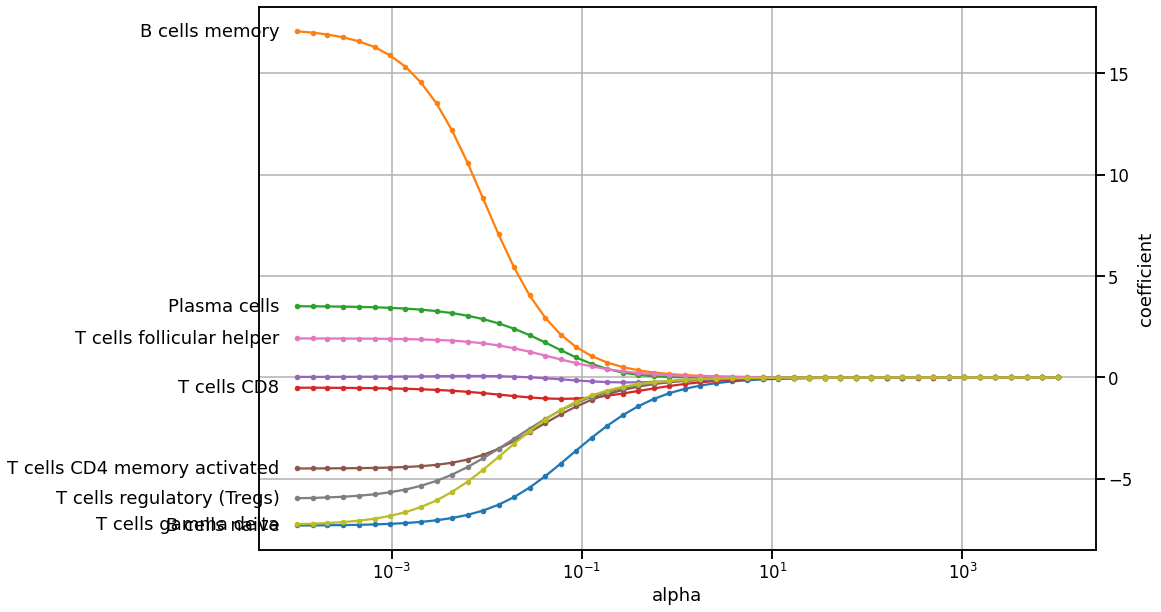

In [ ]:
plot_coefficients(coefficients, n_highlight=8)



```
# This is formatted as code
```

#Multivariate (2nd half)

In [ ]:
data_x=data_x_2

In [ ]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x, data_y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

In [ ]:
estimator.score(data_x, data_y)

0.7225636984502233

In [ ]:
pd.Series(estimator.coef_, index=data_x.columns)

NK cells resting                 9.745149
NK cells activated              18.475060
Monocytes                       -0.134879
Macrophages M0                   0.717693
Macrophages M1                   1.678962
Macrophages M2                   5.680956
Dendritic cells resting         -1.184537
Dendritic cells activated       -2.531440
Mast cells resting              -7.457128
Mast cells activated             2.561619
Eosinophils                 -31912.397513
Neutrophils                     19.866350
dtype: float64

In [ ]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x.values, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

Macrophages M2               0.624744
Neutrophils                  0.576858
NK cells activated           0.575808
Mast cells resting           0.571710
Dendritic cells resting      0.553402
Macrophages M0               0.541030
Macrophages M1               0.527660
Mast cells activated         0.523719
Dendritic cells activated    0.515156
Eosinophils                  0.506751
NK cells resting             0.490990
Monocytes                    0.445049
dtype: float64

In [ ]:
Xt=data_x
y=data_y

alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(Xt.columns))

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(15, 10))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

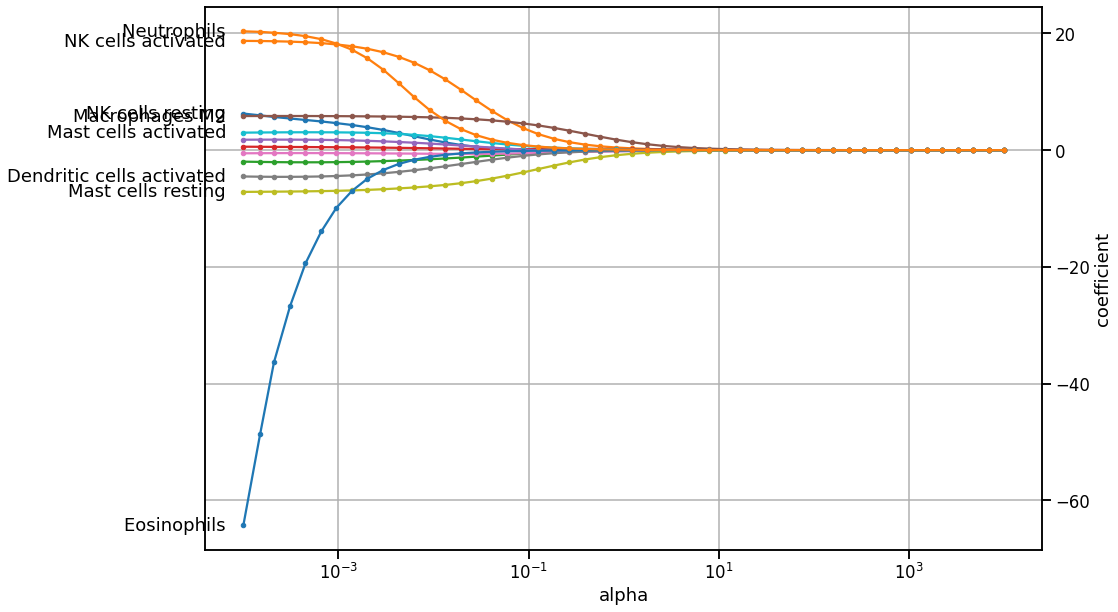

In [ ]:
plot_coefficients(coefficients, n_highlight=8)


#Multivariate (optimized )

In [ ]:
data_merged

,bcr_patient_barcode,history_other_malignancy,margin_status,age_at_diagnosis,menopause_status_imputed,race_imputed,tumor_status_imputed,er_status_by_ihc_imputed,pr_status_by_ihc_imputed,her2_status_by_ihc_imputed,tumor_stage,pt,pn,pm,B cells naive,B cells memory,Plasma cells,T cells CD8,T cells CD4 naive,T cells CD4 memory resting,T cells CD4 memory activated,T cells follicular helper,T cells regulatory (Tregs),T cells gamma delta,NK cells resting,NK cells activated,Monocytes,Macrophages M0,Macrophages M1,Macrophages M2,Dendritic cells resting,Dendritic cells activated,Mast cells resting,Mast cells activated,Eosinophils,Neutrophils,P-value,Pearson Correlation,RMSE
0,TCGA-3C-AAAU,0,0,55,1.0,1,1,1.0,1.0,0.0,0.0,0.5,0.5,0.5,0.163514,0.0,0.125726,0.031051,0,0.032553,0.000000,0.031229,0.052758,0.000000,0.0,0.014749,0.000000,0.184920,0.040579,0.260902,0.008071,0.000000,0.045618,0.0,0.0,0.008330,0.01,0.337433,0.949416
1,TCGA-3C-AALI,0,0,50,4.0,2,0,1.0,1.0,1.0,4.0,3.5,1.0,0.0,0.026535,0.0,0.002263,0.146543,0,0.213623,0.010506,0.061948,0.062993,0.015586,0.0,0.000000,0.000000,0.221950,0.103796,0.062647,0.000000,0.034762,0.035095,0.0,0.0,0.001752,0.12,0.107088,1.059505
2,TCGA-3C-AALJ,0,0,62,4.0,2,0,1.0,1.0,0.5,4.0,3.5,1.0,0.0,0.082361,0.0,0.019830,0.211139,0,0.185140,0.028396,0.018098,0.071896,0.000000,0.0,0.000000,0.000000,0.178111,0.071486,0.114387,0.000000,0.000000,0.019158,0.0,0.0,0.000000,0.01,0.355029,0.939905
3,TCGA-3C-AALK,0,1,52,3.0,2,0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.059360,0.0,0.007169,0.147073,0,0.256614,0.006647,0.029809,0.010244,0.000000,0.0,0.057096,0.026471,0.067364,0.088859,0.136827,0.017657,0.000000,0.088808,0.0,0.0,0.000000,0.10,0.118337,1.041601
4,TCGA-4H-AAAK,0,0,50,4.0,1,0,1.0,1.0,0.5,5.0,3.5,4.0,0.0,0.045901,0.0,0.013257,0.067072,0,0.209942,0.000000,0.070571,0.005324,0.000000,0.0,0.025721,0.020414,0.137158,0.077281,0.186247,0.003476,0.011387,0.126248,0.0,0.0,0.000000,0.03,0.187787,1.005561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,TCGA-WT-AB44,0,0,77,4.0,1,0,1.0,1.0,0.0,1.0,2.0,0.0,0.5,0.090068,0.0,0.009526,0.079382,0,0.100526,0.014386,0.117280,0.016399,0.000000,0.0,0.009787,0.000000,0.196089,0.056737,0.162112,0.040547,0.033008,0.074153,0.0,0.0,0.000000,0.08,0.123148,1.032359
958,TCGA-XX-A899,0,0,46,4.0,1,0,1.0,1.0,0.0,5.0,2.0,4.0,0.5,0.141980,0.0,0.022749,0.125724,0,0.251630,0.041777,0.000000,0.006963,0.000000,0.0,0.000000,0.003120,0.131413,0.060523,0.120492,0.000000,0.000900,0.092697,0.0,0.0,0.000000,0.01,0.394596,0.918532
959,TCGA-XX-A89A,0,0,68,4.0,1,0,1.0,1.0,0.0,4.0,5.5,0.0,0.5,0.152378,0.0,0.066398,0.076364,0,0.277219,0.013185,0.000000,0.021180,0.000000,0.0,0.017377,0.012091,0.099863,0.079194,0.142459,0.000000,0.000000,0.041422,0.0,0.0,0.000900,0.01,0.384044,0.923957
960,TCGA-Z7-A8R5,1,2,61,4.0,1,0,1.0,1.0,0.0,5.0,5.5,1.0,0.5,0.116900,0.0,0.034830,0.183989,0,0.058776,0.008930,0.035683,0.027816,0.000000,0.0,0.047820,0.052850,0.141588,0.015652,0.171387,0.008498,0.000000,0.095280,0.0,0.0,0.000000,0.01,0.328921,0.946772


In [ ]:

# coefficient abs >=2???
#subset_opt=['B cells naive','B cells memory','T cells CD4 memory activated','T cells follicular helper','T cells regulatory (Tregs)','NK cells resting','NK cells activated','Macrophages M1','Macrophages M2','Mast cells resting','Mast cells activated','Eosinophils','Neutrophils']
# score >0.5
'''
subset_opt=['menopause_status_imputed','race_imputed','tumor_status_imputed','er_status_by_ihc_imputed','pr_status_by_ihc_imputed','her2_status_by_ihc_imputed','tumor_stage','pt','pn','pm',
            'Plasma cells','B cells naive','B cells memory','T cells gamma delta','T cells CD8','T cells CD4 memory resting','T cells follicular helper','T cells regulatory (Tregs)',
            'Macrophages M2','Neutrophils', 'NK cells activated','Mast cells resting','Dendritic cells resting','Macrophages M0','Macrophages M1','Mast cells activated','Eosinophils']
'''
# excluded: T cells CD8 (-0.327759);T cells gamma delta (-0.019309);T cells CD4 memory resting (-1.313042); Monocytes(-1.370939); Macrophages M0 (0.721107); Dendritic cells resting (-0.334207); Dendritic cells activated (-1.944610)

#data_x_opt=data_merged[subset_opt]
#data_x=data_x_opt

"\nsubset_opt=['menopause_status_imputed','race_imputed','tumor_status_imputed','er_status_by_ihc_imputed','pr_status_by_ihc_imputed','her2_status_by_ihc_imputed','tumor_stage','pt','pn','pm',\n            'Plasma cells','B cells naive','B cells memory','T cells gamma delta','T cells CD8','T cells CD4 memory resting','T cells follicular helper','T cells regulatory (Tregs)',\n            'Macrophages M2','Neutrophils', 'NK cells activated','Mast cells resting','Dendritic cells resting','Macrophages M0','Macrophages M1','Mast cells activated','Eosinophils']\n"

In [ ]:
#subset_opt=['menopause_status_imputed','race_imputed','tumor_status_imputed','er_status_by_ihc_imputed','pr_status_by_ihc_imputed','her2_status_by_ihc_imputed','tumor_stage','pt','pn','pm',
#            'Plasma cells','B cells naive','B cells memory','T cells gamma delta','T cells CD8','T cells CD4 memory resting','T cells follicular helper','T cells regulatory (Tregs)',
#            'Macrophages M2','Neutrophils', 'NK cells activated','Mast cells resting','Dendritic cells resting','Macrophages M0','Macrophages M1','Mast cells activated','Eosinophils']
subset_opt=['history_other_malignancy','margin_status','age_at_diagnosis','menopause_status_imputed','tumor_status_imputed','er_status_by_ihc_imputed','pr_status_by_ihc_imputed','her2_status_by_ihc_imputed','tumor_stage','pt','pn','pm',
            'Plasma cells','B cells naive','B cells memory','T cells gamma delta','T cells CD8','T cells CD4 memory resting','T cells follicular helper','T cells regulatory (Tregs)',
            'Macrophages M2','Neutrophils', 'NK cells activated','Mast cells resting','Dendritic cells resting','Macrophages M0','Macrophages M1','Mast cells activated','Eosinophils']

data_x_opt=data_merged[subset_opt]
data_x=data_x_opt

In [ ]:
data_x

,history_other_malignancy,margin_status,age_at_diagnosis,menopause_status_imputed,tumor_status_imputed,er_status_by_ihc_imputed,pr_status_by_ihc_imputed,her2_status_by_ihc_imputed,tumor_stage,pt,pn,pm,Plasma cells,B cells naive,B cells memory,T cells gamma delta,T cells CD8,T cells CD4 memory resting,T cells follicular helper,T cells regulatory (Tregs),Macrophages M2,Neutrophils,NK cells activated,Mast cells resting,Dendritic cells resting,Macrophages M0,Macrophages M1,Mast cells activated,Eosinophils
0,0,0,55,1.0,1,1.0,1.0,0.0,0.0,0.5,0.5,0.5,0.125726,0.163514,0.0,0.000000,0.031051,0.032553,0.031229,0.052758,0.260902,0.008330,0.014749,0.045618,0.008071,0.184920,0.040579,0.0,0.0
1,0,0,50,4.0,0,1.0,1.0,1.0,4.0,3.5,1.0,0.0,0.002263,0.026535,0.0,0.015586,0.146543,0.213623,0.061948,0.062993,0.062647,0.001752,0.000000,0.035095,0.000000,0.221950,0.103796,0.0,0.0
2,0,0,62,4.0,0,1.0,1.0,0.5,4.0,3.5,1.0,0.0,0.019830,0.082361,0.0,0.000000,0.211139,0.185140,0.018098,0.071896,0.114387,0.000000,0.000000,0.019158,0.000000,0.178111,0.071486,0.0,0.0
3,0,1,52,3.0,0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.007169,0.059360,0.0,0.000000,0.147073,0.256614,0.029809,0.010244,0.136827,0.000000,0.057096,0.088808,0.017657,0.067364,0.088859,0.0,0.0
4,0,0,50,4.0,0,1.0,1.0,0.5,5.0,3.5,4.0,0.0,0.013257,0.045901,0.0,0.000000,0.067072,0.209942,0.070571,0.005324,0.186247,0.000000,0.025721,0.126248,0.003476,0.137158,0.077281,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,0,0,77,4.0,0,1.0,1.0,0.0,1.0,2.0,0.0,0.5,0.009526,0.090068,0.0,0.000000,0.079382,0.100526,0.117280,0.016399,0.162112,0.000000,0.009787,0.074153,0.040547,0.196089,0.056737,0.0,0.0
958,0,0,46,4.0,0,1.0,1.0,0.0,5.0,2.0,4.0,0.5,0.022749,0.141980,0.0,0.000000,0.125724,0.251630,0.000000,0.006963,0.120492,0.000000,0.000000,0.092697,0.000000,0.131413,0.060523,0.0,0.0
959,0,0,68,4.0,0,1.0,1.0,0.0,4.0,5.5,0.0,0.5,0.066398,0.152378,0.0,0.000000,0.076364,0.277219,0.000000,0.021180,0.142459,0.000900,0.017377,0.041422,0.000000,0.099863,0.079194,0.0,0.0
960,1,2,61,4.0,0,1.0,1.0,0.0,5.0,5.5,1.0,0.5,0.034830,0.116900,0.0,0.000000,0.183989,0.058776,0.035683,0.027816,0.171387,0.000000,0.047820,0.095280,0.008498,0.141588,0.015652,0.0,0.0


In [ ]:
#not stratified test accuracy
from sksurv.metrics import concordance_index_censored
x_train,x_test,y_train,y_test=train_test_split(
    data_x,data_y,train_size=0.8,test_size=0.2,random_state=42)
estimator_cox = CoxPHSurvivalAnalysis()
estimator_cox.fit(x_train, y_train)
x_test = x_test.astype('int32')
prediction = estimator_cox.predict(x_test)
result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
result[0]

/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=8.36872e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=3.07867e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=1.13258e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=4.16655e-18): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=1.

0.7701149425287356

In [ ]:
from sksurv.metrics import concordance_index_censored
sum_train =0
sum_test = 0
for i in range(42,47):
  x_train,x_test,y_train,y_test=train_test_split(
    data_x,data_y,train_size=0.8,test_size=0.2,random_state=i)
  estimator_cox = CoxPHSurvivalAnalysis()
  estimator_cox.fit(x_train, y_train)
  x_test = x_test.astype('int32')
  prediction = estimator_cox.predict(x_test)
  result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
  #print("tain_result:", estimator_cox.score(x_train, y_train))
  sum_train+=estimator_cox.score(x_train, y_train)
  #print("test_result:", result[0])
  sum_test+=result[0]
  #print(i)


/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=8.36872e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=3.07867e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=1.13258e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=4.16655e-18): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=1.

In [ ]:
#non-stratified cox 
print(sum_train/5)
print(sum_test/5)

0.8856840330652991
0.8303923199635788


In [ ]:
#not stratified train accuracy
estimator_cox.score(x_train, y_train)

0.8962023160762943

In [ ]:
#stratified test accuracy 
sum_test=0
sum_train=0
y_for_split = df_y[['vital_status_boolean']].to_records(index= False)
for i in range(42,47):
  x_train,x_test,y_train,y_test=train_test_split(
      data_x,data_y,train_size=0.8,test_size=0.2,random_state=i, stratify=y_for_split)
  estimator_str = CoxPHSurvivalAnalysis()
  estimator_str.fit(x_train, y_train)
  x_test = x_test.astype('int32')
  prediction_str = estimator_str.predict(x_test)
  result_str = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction_str)
  result_str[0]
  print("tain_result:", estimator_cox.score(x_train, y_train))
  sum_train+=estimator_str.score(x_train, y_train)
  print("test_result:", result[0])
  sum_test+=result[0]

/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=4.69636e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=1.7277e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=6.35588e-18): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=2.3382e-18): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)


tain_result: 0.8378936499741869
test_result: 0.847045191193511


/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=5.36044e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=1.97201e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=7.25463e-18): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=2.66883e-18): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=9.

tain_result: 0.8564138050341666
test_result: 0.847045191193511


/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=1.02481e-16): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=3.7139e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=1.36624e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=5.02614e-18): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=1.8

tain_result: 0.855001189815182
test_result: 0.847045191193511


/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=5.11375e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=1.88126e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=6.92077e-18): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=2.54601e-18): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=9.

tain_result: 0.8432117527862208
test_result: 0.847045191193511


/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=4.40165e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=1.61929e-17): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=5.95703e-18): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)
/usr/local/lib/python3.7/dist-packages/sksurv/linear_model/coxph.py:426: LinAlgWarning: Ill-conditioned matrix (rcond=2.19147e-18): result may not be accurate.
  overwrite_a=False, overwrite_b=False, check_finite=False)


tain_result: 0.8500442941129097
test_result: 0.847045191193511


In [ ]:
print(sum_train/5)
print(sum_test/5)

0.8611568138720201
0.847045191193511


In [ ]:
estimator_str.score(x_train, y_train)

0.8681646130305227

In [ ]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x.values, data_y)
pd.Series(scores, index=data_x.columns).sort_values(ascending=False)

tumor_status_imputed          0.729446
pn                            0.697111
age_at_diagnosis              0.666010
Plasma cells                  0.658524
tumor_stage                   0.639585
Macrophages M2                0.624744
pt                            0.617599
pr_status_by_ihc_imputed      0.616286
B cells naive                 0.608826
er_status_by_ihc_imputed      0.604623
B cells memory                0.593643
T cells gamma delta           0.587838
menopause_status_imputed      0.585868
Neutrophils                   0.576858
NK cells activated            0.575808
Mast cells resting            0.571710
pm                            0.567428
T cells CD8                   0.558970
Dendritic cells resting       0.553402
her2_status_by_ihc_imputed    0.552246
margin_status                 0.542606
Macrophages M0                0.541030
T cells follicular helper     0.537457
history_other_malignancy      0.534988
T cells CD4 memory resting    0.528579
Macrophages M1           

In [ ]:
pd.Series(estimator_str.coef_, index=x_train.columns)

history_other_malignancy          1.647162
margin_status                     0.044223
age_at_diagnosis                  0.050937
menopause_status_imputed         -0.149210
tumor_status_imputed              2.173910
er_status_by_ihc_imputed         -0.711885
pr_status_by_ihc_imputed         -1.150544
her2_status_by_ihc_imputed        0.540959
tumor_stage                      -0.408138
pt                                0.285313
pn                                0.526124
pm                               -0.329643
Plasma cells                      0.311007
B cells naive                    -1.482638
B cells memory                   15.193054
T cells gamma delta              -1.794002
T cells CD8                      -2.473959
T cells CD4 memory resting        1.964130
T cells follicular helper         7.235946
T cells regulatory (Tregs)       -8.127297
Macrophages M2                    6.481704
Neutrophils                      12.615329
NK cells activated                5.218295
Mast cells 

#PCOX

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
#non-stratified 
#pcox test accuracy
#train with train and test with test
sum_test=0
sum_train=0
Xt=data_x
y=data_y
y_for_split = df_y[['vital_status_boolean']].to_records(index= False)
for i in range(42,47):
  x_train,x_test,y_train,y_test=train_test_split(
      Xt,y,train_size=0.8,test_size=0.2,random_state=i)
  cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
  cox_elastic_net.fit(x_train, y_train)
  x_test = x_test.astype('int32')
  prediction = cox_elastic_net.predict(x_test)
  result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
  result[0]
  print("tain_result:", cox_elastic_net.score(x_train, y_train))
  sum_train+=cox_elastic_net.score(x_train, y_train)
  print("test_result:", result[0])
  sum_test+=result[0]

tain_result: 0.8752287392853704
test_result: 0.7750410509031199
tain_result: 0.8708768778576094
test_result: 0.8333333333333334
tain_result: 0.8604392229133072
test_result: 0.8269961977186312
tain_result: 0.86581836752064
test_result: 0.7949308755760369
tain_result: 0.8552452316076294
test_result: 0.8273464658169177


In [ ]:
print(sum_test/5)
print(sum_train/5)

0.8115295846696078
0.8655216878369114


In [ ]:

Xt=data_x
y=data_y
x_train,x_test,y_train,y_test=train_test_split(
    Xt,y,train_size=0.8,test_size=0.2,random_state=42)
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(x_train, y_train)
x_test = x_test.astype('int32')
prediction = cox_elastic_net.predict(x_test)
result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
result[0]

0.7750410509031199

In [ ]:
#pcox train accuracy
cox_elastic_net.score(x_train, y_train)

0.8752287392853704

In [ ]:
#stratified test accuracy multiple sampling 
sum_test=0
sum_train=0
for i in range(42,47):
  x_train,x_test,y_train,y_test=train_test_split(
    Xt,y,train_size=0.8,test_size=0.2,random_state=i,stratify=y_for_split)
  cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
  cox_elastic_net.fit(x_train, y_train)
  x_test = x_test.astype('int32')
  prediction = cox_elastic_net.predict(x_test)
  result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
  result[0]
  print("tain_result:", cox_elastic_net.score(x_train, y_train))
  sum_train+=cox_elastic_net.score(x_train, y_train)
  print("test_result:", result[0])
  sum_test+=result[0]

print(sum_test/5)
print(sum_train/5)

tain_result: 0.8285148855618655
test_result: 0.9388209121245829
tain_result: 0.8550298417091947
test_result: 0.8973799126637555
tain_result: 0.8561910049972238
test_result: 0.9016641452344932
tain_result: 0.838483620398514
test_result: 0.8861209964412812
tain_result: 0.8424337601675123
test_result: 0.8974719101123596
0.9042915753152944
0.8441306225668621


In [ ]:
#stratified test accuracy
x_train,x_test,y_train,y_test=train_test_split(
    Xt,y,train_size=0.8,test_size=0.2,random_state=42,stratify=y_for_split)
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(x_train, y_train)
x_test = x_test.astype('int32')
prediction = cox_elastic_net.predict(x_test)
result = concordance_index_censored(y_test["vital_status_boolean"], y_test["survival_in_days"], prediction)
result[0]

0.9388209121245829

In [ ]:
#stratified train accuracy
cox_elastic_net.score(x_train, y_train)

0.8285148855618655

In [ ]:
cox_elastic_net.score(x_test, y_test)

0.9388209121245829

In [ ]:
import seaborn as sns
sns.set_context('talk')

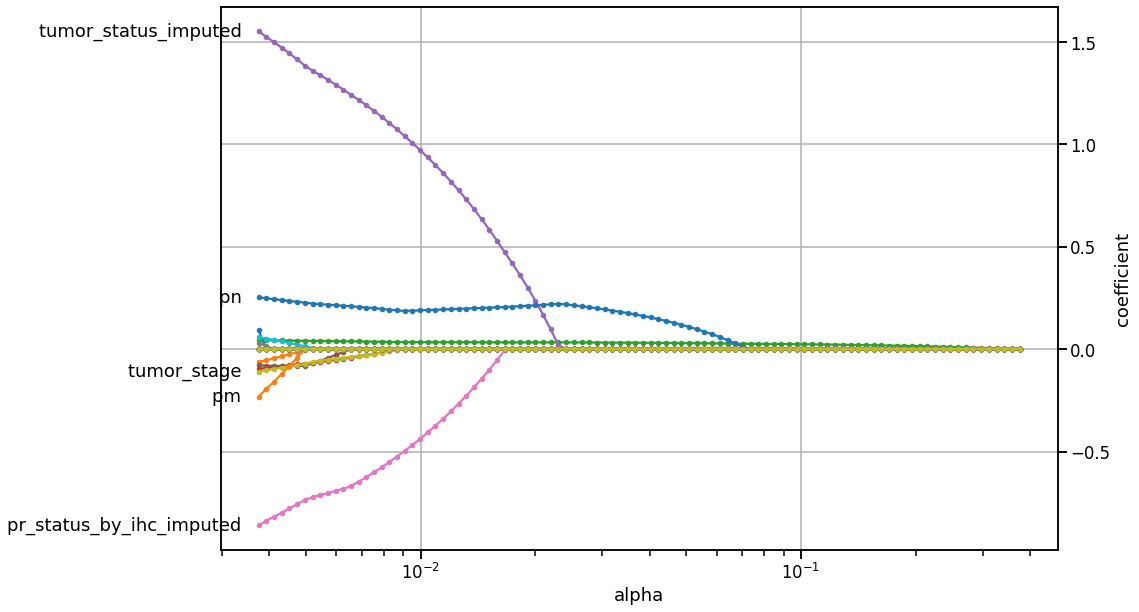

In [ ]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_,
    index=Xt.columns,
    columns=np.round(cox_elastic_net.alphas_, 7)
)
plot_coefficients(coefficients_elastic_net, n_highlight=5)

In [ ]:
plt.savefig('/content/drive/MyDrive/Year Three/CS4220yxy/CT_PCOX_ENET.svg')

<Figure size 432x288 with 0 Axes>

In [ ]:
alphas = 10. ** np.linspace(-4, 4, 50)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(Xt, y)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(Xt.columns))

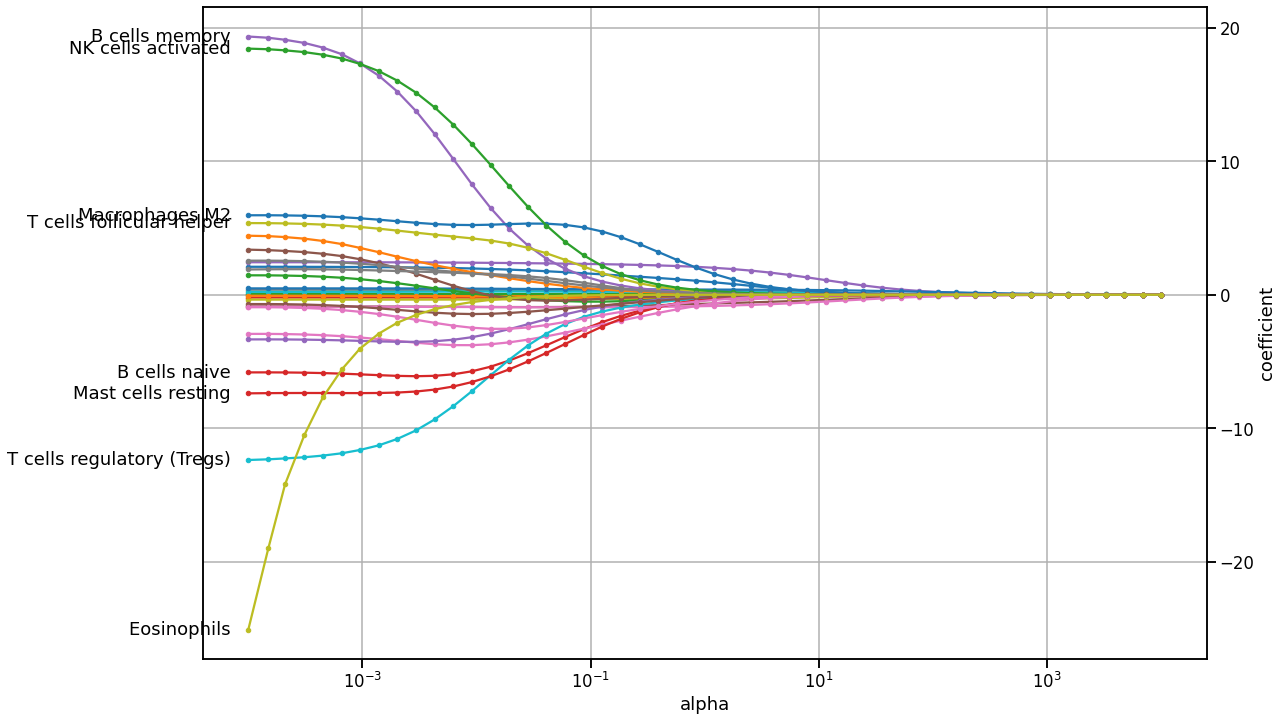

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(18, 12))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )
        #ax.legend(['B cells memory', 'NK cells activated', 'Macrophages M2','B cells naive', 'Mast cell resting', 'T cell regulatory (Tregs)','Eosinophils'],loc='upper right', frameon=False)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
    

plot_coefficients(coefficients, n_highlight=8)

In [ ]:
#savefig('/content/drive/MyDrive/Year Three/CS4220yxy/CT_PCOX_Ridge.svg')